# Training code for Project 2 (i.e. Reacher environment) in Udacity's Deep Reinforcement Learning nanodegree course

---

In this notebook, we will use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).




## 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import time
import os
import sys
import pickle
from collections import deque

import matplotlib.pyplot as plt

from unityagents import UnityEnvironment
import numpy as np
import torch

from udacity.ddpg_agent import Agent

DDPG agent  cuda:0


In [2]:

print('python version:', os.path.dirname(sys.executable))
print('torch version:', torch.__version__)


python version: /home/life/.pyenv/versions/3.6.11/envs/upy36/bin
torch version: 1.7.0


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded. See README.md for details of where to download these files.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
# Here, I've unzipped the 'Reacher_Linux' folder in the same folder as this notebook:
file_name = 'Reacher_Linux/Reacher.x86_64'
env = UnityEnvironment(file_name=file_name)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## 3. Test run an agent in the environment

Below, an agent that makes random actions is included for testing the environment, so that we can be sure that it is working as expected.

In [6]:
def run_random_agent():
    """This uses a random agent to just test out the unity environment.
    
    The code was taken from the Udacity nanodegree course.
    """
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    count = 0
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        count = count + 1
        
        if rewards[0] > 0:
            print('actions.shape', actions.shape)
            print('actions[0]', actions[0])
            print('next_states.shape', next_states.shape)
            print('next_states[0][0:10]', next_states[0][0:10])
            print('len(rewards)', len(rewards))
            print('rewards', rewards)
            print('')
        
        if np.any(dones):                                  # exit loop if episode finished
            break
            print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
    print('count:', count)
    return scores

#scores = run_random_agent()
#print(len(scores))
#plt.plot(scores)
#scores

#assert False

## 4. Train an agent using DDPG (Deep Deterministic Policy Gradient)
In this section, we will train an agent using the DDPG algorithm over many episodes.

In [7]:
def ddpg(agent, n_episodes=1000, max_t=2000, train=True):
    """Trains an agent over multiple episodes using the DDPG algorithm, and returns a list of final scores for the episodes ran.
    
    Parameters
    ----------
    agent
        A DDPG agent
        
    n_episodes: int
        Maximum number of training episodes
        
    max_t: int
        Maximum number of time steps per episode. Greater this number, the agent is more likely to accumulate larger total reward.
        
    train : bool
        If True, then the agent will be trained. If False, the agent w/ preloaded weights will interact w/ the environment wo/ training.
        
    Returns
    -------
    scores: list
        A list of final scores for the episodes ran.
        
    Notes
    -----
    The `ddpg` function was taken from the Udacity nanodegree Deep Reinforcement Learning course, and adapted to the Reacher unity environment.
    """
    
    fn_scores = 'scores_train.pkl'
    if train==False:
        fn_scores = 'scores_test.pkl'
        
    all_scores = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        agent.reset()
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        #env_info = env.reset(train_mode=False)[brain_name] # reset the environment
        
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        
        for t in range(max_t):
            actions = agent.act(states)         
      
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                  # see if episode has finished
            
            if train == True:
                agent.step(states, actions, rewards, next_states, dones)
            
            states = next_states
            scores += rewards
            
            
            # Each episode is 1000 steps long. However, here we are going beyond to 'max_t=2000' steps.
            # This means the agent has more chance to accumulate rewards due to longer episode.
            #if np.any(dones):                                  # exit loop if episode finished
            #    #print('episode:', i_episode, ' t:', t)  # 
            #    break    
            
        
        avg_score = np.mean(scores)
        scores_window.append(avg_score)
        all_scores.append(avg_score)

        # Save data at regular interval:
        if i_episode % 100 == 0:
            with open(fn_scores, 'wb') as f:
                pickle.dump(all_scores, f)
                
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth') 
          
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if train == True:
            if np.mean(scores_window) >= 30.0:
                print('Environment solved after {} episodes'.format(i_episode + 1))
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth') 

                break
          
    
    return all_scores


In [8]:
# Train an agent:
seed = 0
agent = Agent(state_size, action_size, random_seed=seed)

ts_i = time.time()

#scores = ddpg(agent, n_episodes=300)
#scores = ddpg(agent, n_episodes=1)    # For troubleshooting.
scores = ddpg(agent, n_episodes=5000)

ts_j = time.time()
ts_diff = ts_j - ts_i
print('Training took:', ts_diff/60., ' minutes')

# Save scores:
with open('scores_train.pkl', 'wb') as f:
    pickle.dump(scores, f)

Episode 100	Average Score: 5.66
Episode 200	Average Score: 12.84
Episode 300	Average Score: 19.72
Episode 400	Average Score: 28.18
Episode 416	Average Score: 30.19Environment solved after 417 episodes
Training took: 91.98610140482585  minutes


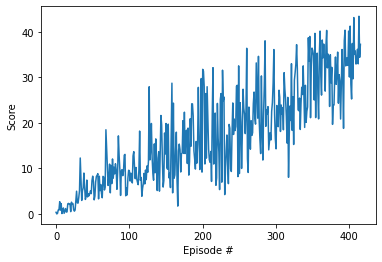

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 5. Confirm that the saved weights contain the trained agent that performs better

In this section, we will load learned neural network weights from files `checkpoint_actor.pth` and `checkpoint_critic.pth` into an agent, and re-run agent without training, and evaluate its performance.

Note that an average score of 30+ for 100 consecutive episodes is considered "solving" the environment.

In [10]:
# Load the model weights from the previous Training step into a new agent:

agent2 = Agent(state_size, action_size, random_seed=0)
agent2.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location=torch.device('cpu')))
agent2.critic_local.load_state_dict(torch.load('checkpoint_critic.pth', map_location=torch.device('cpu')))

agent2.actor_local.eval()
agent2.critic_local.eval()



Critic(
  (fcs1): Linear(in_features=33, out_features=512, bias=True)
  (fc2): Linear(in_features=516, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (normalizer): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [11]:
# Run the new agent for n_episodes:
scores_test = ddpg(agent2, n_episodes=100, train=False)

with open('scores_test.pkl', 'wb') as f:
    pickle.dump(scores_test, f)

Episode 100	Average Score: 35.52


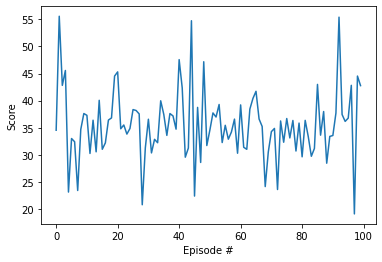

In [12]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_test)), scores_test)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

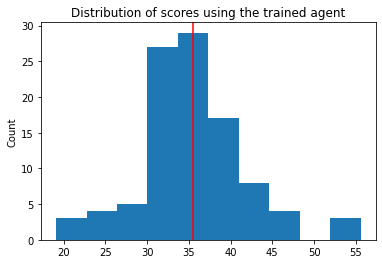

In [13]:
## Distribution of scores
score_mean = np.mean(scores_test)

plt.hist(scores_test, bins=10)
plt.ylabel('Count')
plt.title('Distribution of scores using the trained agent')
plt.axvline(x=score_mean, color='red')

In [14]:
print('Mean Score:', score_mean)

Mean Score: 35.516599206142125


In [15]:
env.close()